### Forecast experiment 1 - Sine wave

This is usually considered the "hello world" of time series forecasting.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error

import keras
seed = 101
keras.utils.set_random_seed(seed)

In [67]:
X_train = np.arange(0,100,0.5) 
y_train = np.sin(X_train)

X_test = np.arange(100,200,0.5) 
y_test = np.sin(X_test)

n_features = 1

train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))


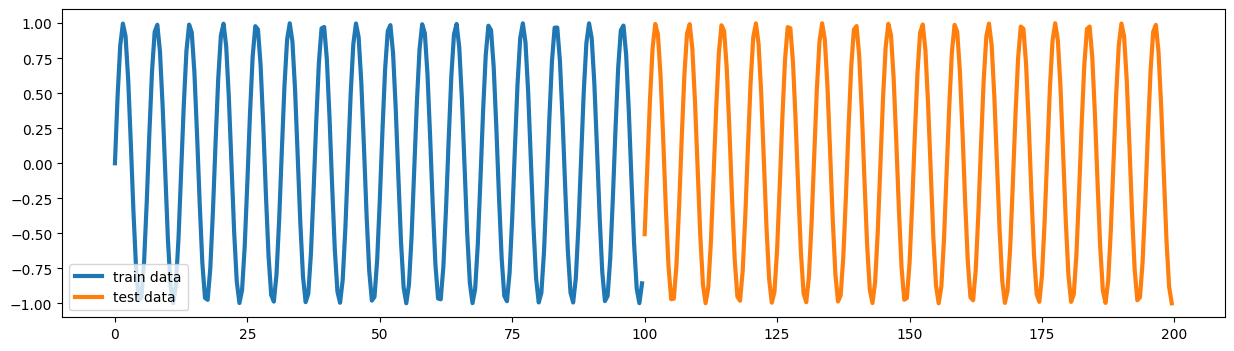

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [69]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# the variable that determines how many points
# back into the past the model attempts to learn
look_back  = 20
batch_size = 10

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# TimeseriesGenerators were deprecated by TensorFlow developers
# during October 2024
# this means, in some unknown future TensorFlow -version
# this feature will removed
# check the other version of this notebook on how to replace
# TimeseriesGenerator with a TensorFlow Dataset
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [70]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM
from keras.layers import Dense

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 8

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(LSTM(n_neurons))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

initial_weights = model.get_weights()

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=100, verbose=1, validation_data=test_generator)


Epoch 1/100


c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4542 - val_loss: 0.4329
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4192 - val_loss: 0.3947
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3753 - val_loss: 0.3429
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3144 - val_loss: 0.2738
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2337 - val_loss: 0.1850
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1389 - val_loss: 0.0882
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0540 - val_loss: 0.0229
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0042
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 9.3707e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4559e-04

**Training metrics**

<Axes: >

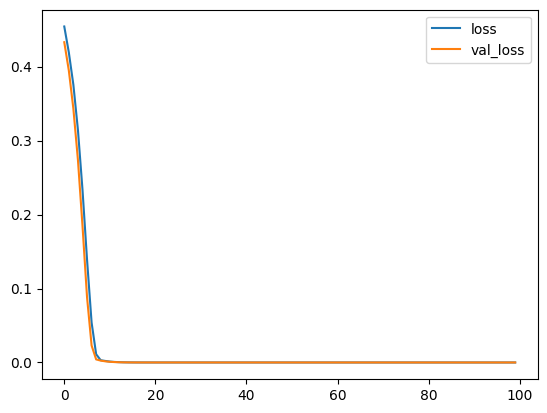

In [71]:
# the usual training metrics visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [72]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 4.9071e-06
Training loss: 4.907116817776114e-06
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 4.8995e-06
Testing loss: 4.899477971775923e-06


**Test predictions**

In [73]:
test_predictions  = model.predict(test_generator)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step


**Conventional regression metrics + MAPE**

In [74]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
0.95 %

MAE
0.0 units

MSE
0.0 units^2

RMSE:
0.0 units

R-squared:
1.0


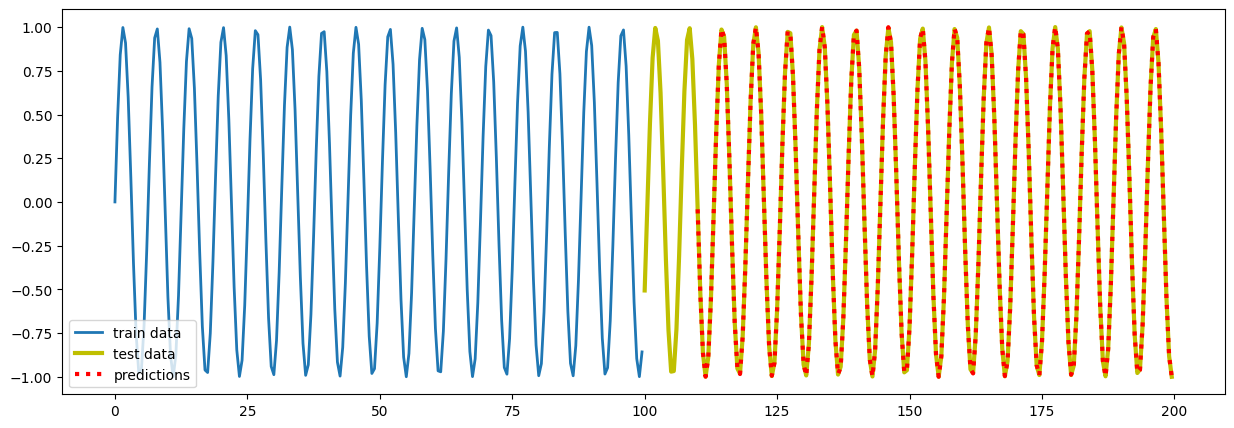

In [75]:
x = np.arange(110,200,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot(x,test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="lower left")
plt.show();

**Extrapolation into the future**

In [76]:
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(320):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

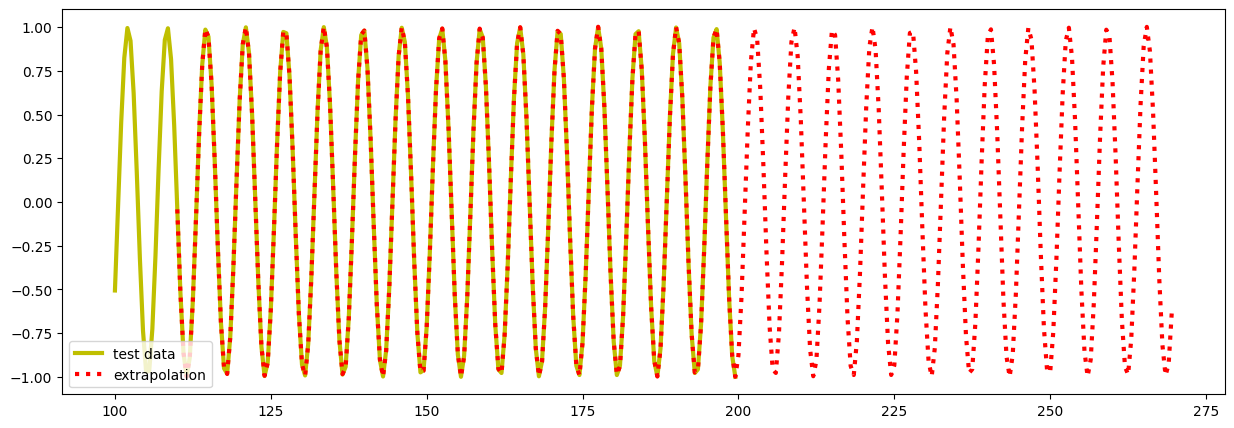

In [77]:
x = np.arange(110,270,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot(x,extrapolation, lw=3, c='r',linestyle = ':', label='extrapolation')
ax.legend(loc="lower left")
plt.show()